In [1]:
options(max.print = 100)
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
enhancers_metadata_path = "Analysis/enhancers/tcea_FANTOM/tcea_FANTOM_enhancers_metadata.txt"


In [2]:
# Parameters
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
enhancers_metadata_path = "Analysis/enhancers/tcea_FANTOM/tcea_FANTOM_enhancers_metadata.txt"


In [3]:
setwd(here::here()) # set working directory to project root
getwd() 

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [4]:
library(dplyr)
library(Matrix)
library(Seurat)
library(ggplot2)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Attaching SeuratObject



‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed



In [5]:
rna_enhancers = readRDS(filtered_erna_path)

In [6]:
rna_enhancers[1:10,1:10]

  [[ suppressing 10 column names ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’, ‘AAACAGCCACACTAAT’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                                         
FANTOM5_10:101475394-101475766 . . .   .      . . . . . .
FANTOM5_10:101754114-101754425 . . .   .      . . . . . .
FANTOM5_10:101942179-101942274 . . .   .      . . . . . .
FANTOM5_10:102140082-102140467 . . .   .      . . . . . .
FANTOM5_10:102284617-102284981 . . .   .      . . . . . .
FANTOM5_10:102284995-102285353 . . . 184.7404 . . . . . .
FANTOM5_10:103238536-103238713 . . .   .      . . . . . .
FANTOM5_10:103575139-103575373 . . .   .      . . . . . .
FANTOM5_10:103699141-103699397 . . .   .      . . . . . .
FANTOM5_10:103708018-103708327 . . .   .      . . . . . .

In [7]:
pbmc_erna = CreateSeuratObject(counts = rna_enhancers, project = "PBMC_eRNA", min.cells = 3, min.features = 3)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [8]:
pbmc_erna

An object of class Seurat 
10457 features across 10513 samples within 1 assay 
Active assay: RNA (10457 features, 0 variable features)

[1] "FANTOM5-4:78774382-78774627"   "FANTOM5-12:47702305-47702647" 
 [3] "FANTOM5-16:74599295-74599588"  "FANTOM5-6:16474193-16474630"  
 [5] "FANTOM5-14:71158950-71159205"  "FANTOM5-17:74413626-74413718" 
 [7] "FANTOM5-12:92428496-92429133"  "FANTOM5-1:17956441-17957463"  
 [9] "FANTOM5-3:112143988-112144379" "FANTOM5-8:38035023-38035257"

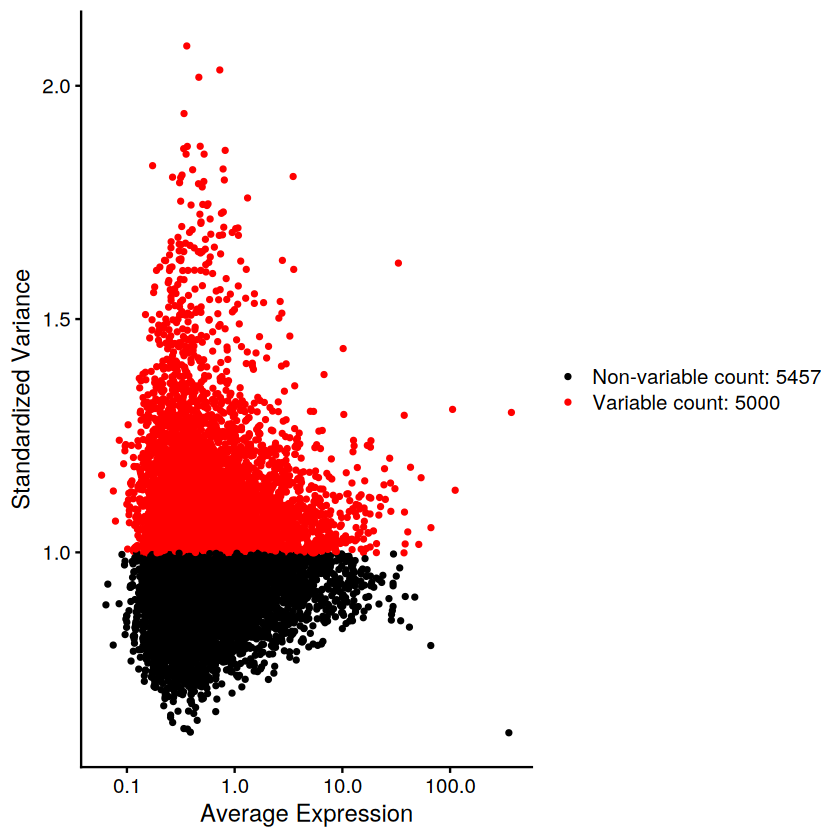

In [9]:

# Normalize and identify variable features
#pbmc_erna <- NormalizeData(pbmc_erna, normalization.method = "LogNormalize", scale.factor = 1e6)
pbmc_erna <- FindVariableFeatures(pbmc_erna, selection.method = "vst", nfeatures = 5000)

# Visualize variable features
top10 <- head(VariableFeatures(pbmc_erna), 10)
top10
VariableFeaturePlot(pbmc_erna)

Centering and scaling data matrix



PC_ 1 
Positive:  FANTOM5-15:45004703-45005017, FANTOM5-7:105922869-105923204, FANTOM5-5:172193800-172194232, FANTOM5-6:14121845-14123283, FANTOM5-10:70849672-70851282, FANTOM5-15:51912435-51913121, FANTOM5-14:75750758-75751180, FANTOM5-6:32555783-32556185, FANTOM5-19:47814150-47814595, FANTOM5-1:28269913-28270209 
	   FANTOM5-17:81038687-81040054, FANTOM5-2:208395422-208395980, FANTOM5-8:90787257-90787620, FANTOM5-19:45980345-45980732, FANTOM5-15:51868984-51870333, FANTOM5-X:23799321-23799855, FANTOM5-1:116918925-116919548, FANTOM5-1:247524183-247524555, FANTOM5-4:17581888-17582305, FANTOM5-17:27619094-27619880 
	   FANTOM5-13:41591294-41591779, FANTOM5-19:2094360-2094773, FANTOM5-1:28199684-28200598, FANTOM5-19:47818553-47819137, FANTOM5-1:31216468-31217229, FANTOM5-18:74841905-74842663, FANTOM5-12:89554110-89556960, FANTOM5-8:56903187-56904166, FANTOM5-13:99933141-99933542, FANTOM5-17:8857526-8857964 
Negative:  FANTOM5-12:9912135-9912729, FANTOM5-14:99726837-99727734, FANTOM5-4:109

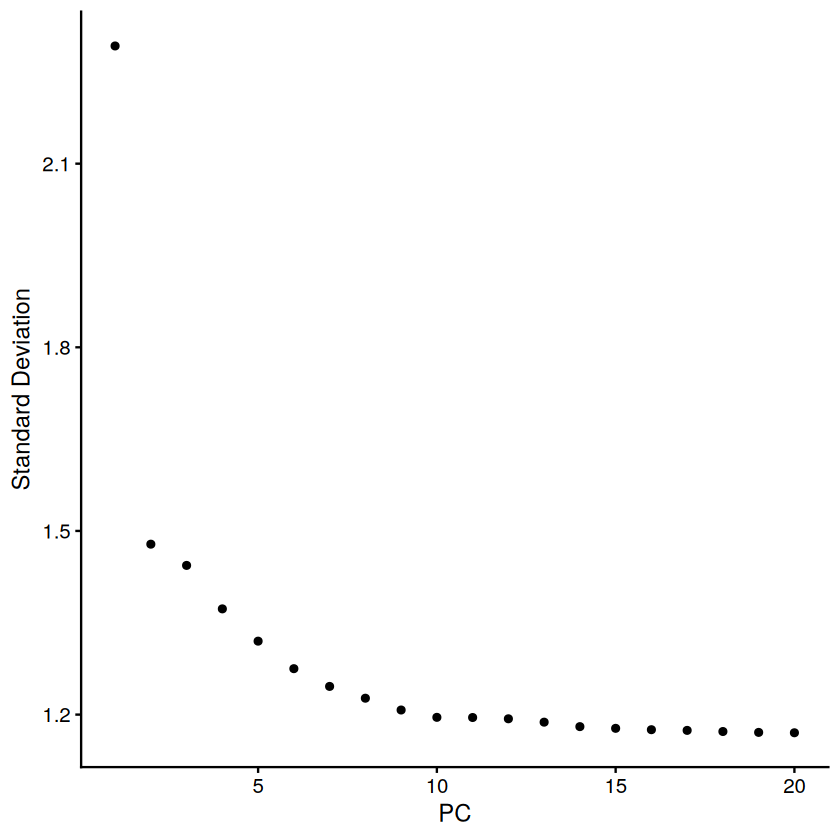

In [10]:
# Scale, PCA
pbmc_erna <- ScaleData(pbmc_erna, features = VariableFeatures(pbmc_erna))
pbmc_erna <- RunPCA(pbmc_erna, features = VariableFeatures(object = pbmc_erna))
ElbowPlot(pbmc_erna)



In [11]:
# Neighborhood graph, clustering and UMAP
pbmc_erna <- FindNeighbors(pbmc_erna, dims = 1:10)
pbmc_erna <- FindClusters(pbmc_erna, resolution = 0.2)



Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10513
Number of edges: 318997

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8965
Number of communities: 5
Elapsed time: 1 seconds


In [12]:
pbmc_erna <- RunUMAP(pbmc_erna, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


12:26:52 UMAP embedding parameters a = 0.9922 b = 1.112



12:26:52 Read 10513 rows and found 10 numeric columns



12:26:52 Using Annoy for neighbor search, n_neighbors = 30



12:26:53 Building Annoy index with metric = cosine, n_trees = 50



0%   10   20   30   40   50   60   70   80   90   100%



[----|----|----|----|----|----|----|----|----|----|



*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


|



12:26:54 Writing NN index file to temp file /tmp/Rtmpze8UUL/file126fc16dcd518c



12:26:54 Searching Annoy index using 1 thread, search_k = 3000



12:26:57 Annoy recall = 100%



12:26:57 Commencing smooth kNN distance calibration using 1 thread


 with target n_neighbors = 30



12:26:58 Initializing from normalized Laplacian + noise (using irlba)



12:26:58 Commencing optimization for 200 epochs, with 427122 positive edges



12:26:58 Using rng type: pcg



12:27:03 Optimization finished



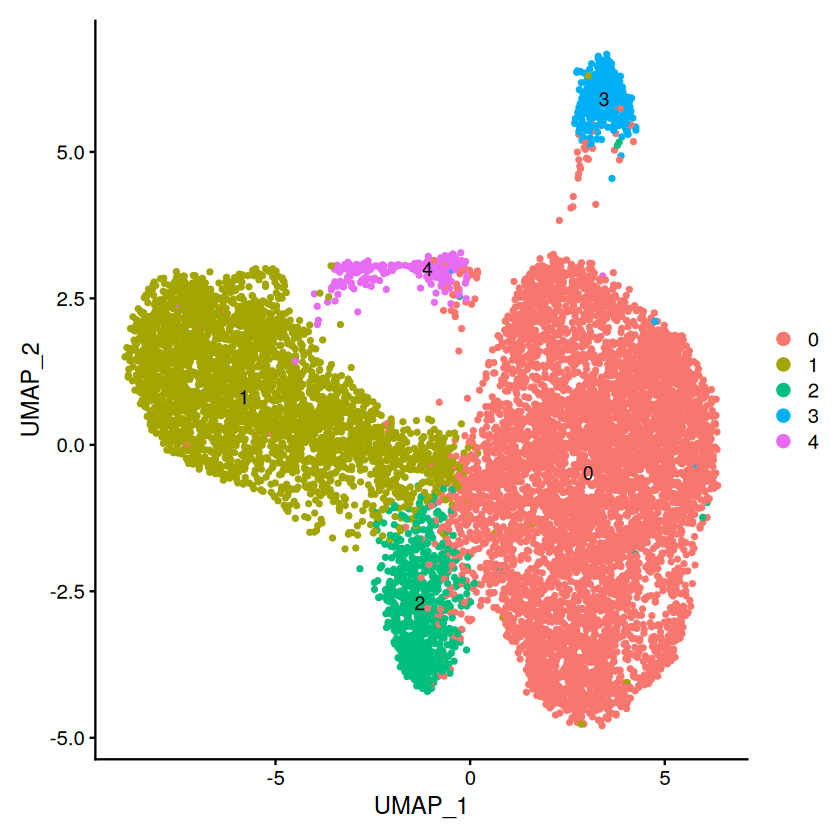

In [13]:
# Plot UMAP
DimPlot(pbmc_erna, reduction = "umap", label = TRUE,pt.size = 1) 

In [14]:
cell_type_idents = readRDS(cell_idents_path)
rownames(cell_type_idents) = gsub("-1","",rownames(cell_type_idents))
head(cell_type_idents)

,pbmc@active.ident
,<fct>
AAACAGCCAATCCCTT,cd4
AAACAGCCAATGCGCT,cd8
AAACAGCCACACTAAT,cd8
AAACAGCCACCAACCG,cd8
AAACAGCCAGGATAAC,cd4
AAACAGCCAGTTTACG,cd4


In [15]:
unique(cell_type_idents[1])

,pbmc@active.ident
,<fct>
AAACAGCCAATCCCTT,cd4
AAACAGCCAATGCGCT,cd8
AAACATGCACCGGCTA,undefined_t_cells
AAACCAACACAATGCC,cd14
AAACCGAAGCTGGACC,cd4_in_cd14
AAAGCAAGTTAACGGC,b_cells
AACAGATAGTAACCCG,cd4_near_b


In [16]:
pbmc_erna  = AddMetaData(object = pbmc_erna, metadata = cell_type_idents,col.name = "cell_type")

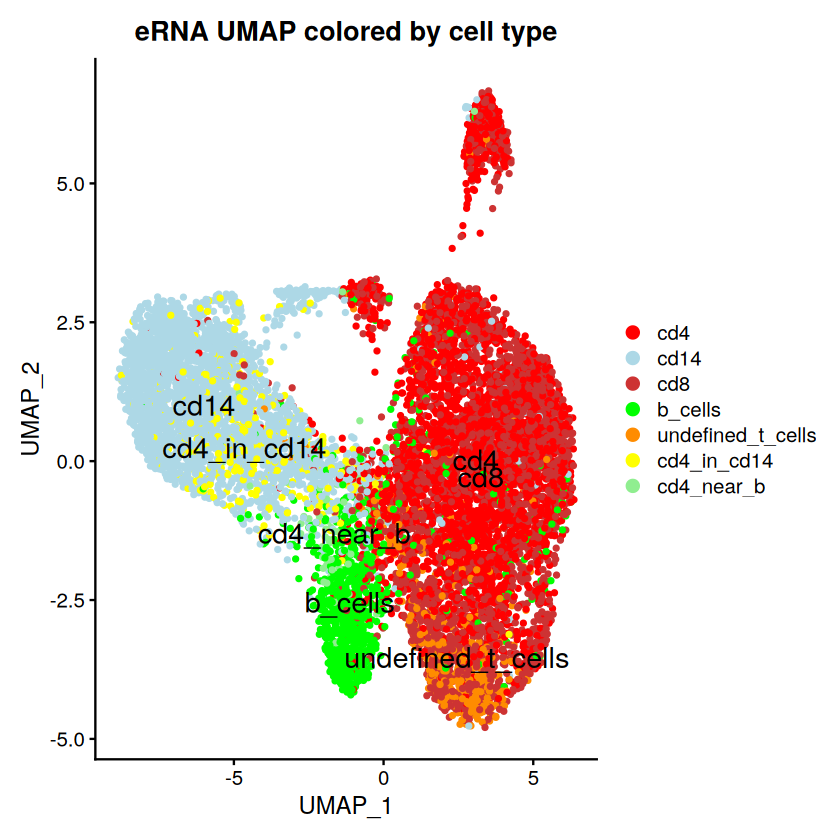

In [17]:
DimPlot(pbmc_erna, reduction = "umap", group.by = "cell_type", label = TRUE,pt.size = 1,label.size = 6)+ 
  ggtitle("eRNA UMAP colored by cell type")+
  #set colors
  scale_color_manual(values =c(
    "cd4" = "red",
    "cd8" = "brown3",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "lightblue",
    "other" = "gray"  # Add other cell types here if needed
))


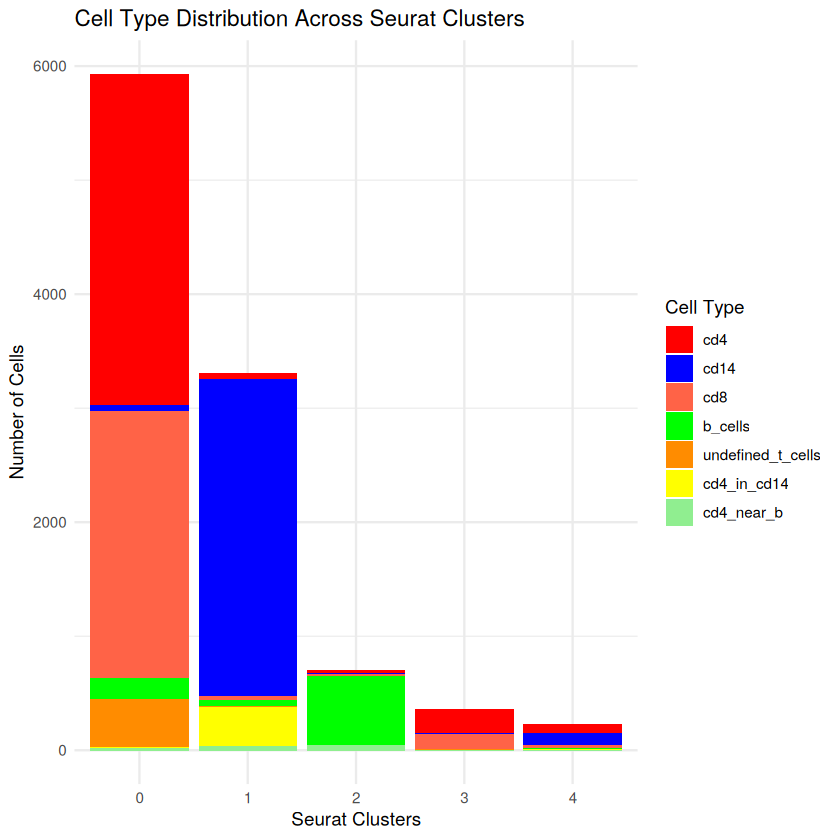

In [18]:
#stacked barplot of cell types per cluster
cluster_celltype_table = table(pbmc_erna$seurat_clusters, pbmc_erna$cell_type)
cluster_celltype_df = as.data.frame(cluster_celltype_table)

ggplot(cluster_celltype_df, aes(x=Var1, y=Freq, fill=Var2)) +
    geom_bar(stat="identity") +
    labs(x="Seurat Clusters", y="Number of Cells", fill="Cell Type") +
    ggtitle("Cell Type Distribution Across Seurat Clusters") +
    theme_minimal()+
    scale_fill_manual(values = c(
    "cd4" = "red",
    "cd8" = "tomato1",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "blue",
    "other" = "gray"  # Add other cell types here if needed
))

In [19]:
cluster_0_vs_cluster1_markers = FindMarkers(pbmc_erna, ident.1 = 0, ident.2 = 1, min.pct = 0)


For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [20]:
dim(cluster_0_vs_cluster1_markers)
head(cluster_0_vs_cluster1_markers,20)

[1] 10266     5

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FANTOM5-18:2848392-2848824,0.000000e+00,-Inf,0.003,0.311,0.000000e+00
FANTOM5-7:105922869-105923204,0.000000e+00,-Inf,0.016,0.377,0.000000e+00
FANTOM5-15:51912435-51913121,1.323228e-277,-Inf,0.001,0.203,1.383699e-273
FANTOM5-6:32555783-32556185,9.778985e-260,-Inf,0.004,0.201,1.022588e-255
FANTOM5-19:47814150-47814595,1.692542e-229,-Inf,0.001,0.170,1.769891e-225
FANTOM5-1:28269913-28270209,2.968182e-197,-Inf,0.004,0.156,3.103827e-193
FANTOM5-8:90787257-90787620,3.063678e-195,-Inf,0.006,0.163,3.203688e-191
FANTOM5-8:56887750-56888682,2.377434e-186,-Inf,0.007,0.158,2.486083e-182
FANTOM5-9:226208-226591,2.235193e-166,-Inf,0.005,0.138,2.337342e-162


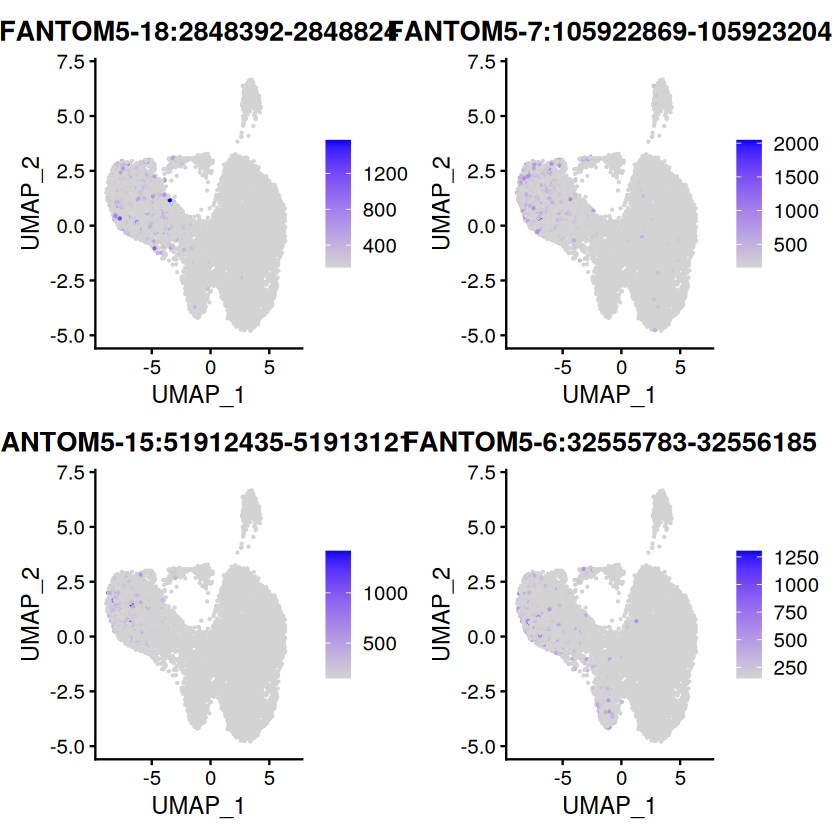

In [21]:
FeaturePlot(pbmc_erna, features = rownames(cluster_0_vs_cluster1_markers)[1:4], min.cutoff = "q9")

In [22]:
top_de_enhancers = rownames(head(cluster_0_vs_cluster1_markers,20)) %>% gsub("-","_",.)
top_de_enhancers

[1] "FANTOM5_18:2848392_2848824"     "FANTOM5_7:105922869_105923204" 
 [3] "FANTOM5_15:51912435_51913121"   "FANTOM5_6:32555783_32556185"   
 [5] "FANTOM5_19:47814150_47814595"   "FANTOM5_1:28269913_28270209"   
 [7] "FANTOM5_8:90787257_90787620"    "FANTOM5_8:56887750_56888682"   
 [9] "FANTOM5_9:226208_226591"        "FANTOM5_11:59941256_59941428"  
[11] "FANTOM5_10:129851192_129851341" "FANTOM5_8:37739186_37739703"   
[13] "FANTOM5_2:16837187_16837623"    "FANTOM5_8:56796346_56796794"   
[15] "FANTOM5_6:144473249_144474108"  "FANTOM5_15:51868984_51870333"  
[17] "FANTOM5_8:37749222_37749683"    "FANTOM5_12:10272963_10273373"  
[19] "FANTOM5_12:10281058_10281708"   "FANTOM5_14:99726837_99727734"

In [23]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = T, sep = "\t", data.table = FALSE)

In [24]:
enhancers_metadata

chr,start,end,id,type,gene_intersection,bp_to_closest_gene,length
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,905373,905830,FANTOM5_1:840753-841210,1,intergenic,18093,457
1,910105,910298,FANTOM5_1:845485-845678,1,intergenic,13625,193
1,921159,921377,FANTOM5_1:856539-856757,1,intergenic,2546,218
1,922876,923268,FANTOM5_1:858256-858648,1,intergenic,655,392
1,933185,933304,FANTOM5_1:868565-868684,1,intronic,0,119
1,983069,983175,FANTOM5_1:918449-918555,1,intergenic,953,106
1,1001272,1001758,FANTOM5_1:936652-937138,1,intronic,0,486
1,1006411,1006755,FANTOM5_1:941791-942135,1,intronic,0,344
1,1010389,1010654,FANTOM5_1:945769-946034,1,intronic,0,265


In [25]:
# deg = cluster_0_vs_cluster1_markers %>% filter(p_val_adj < 0.05 & abs(avg_log2FC) > 2)
# enhancers_metadata$id = gsub("_","-",enhancers_metadata$id)
# rownames(enhancers_metadata) = enhancers_metadata$id
# #barplot how many are intergenic or intragenic
# deg_metadata = enhancers_metadata[match(rownames(deg), enhancers_metadata$id), ]
# table(deg_metadata$gene_intersection )